In [1]:
import pandas as pd
import numpy as np
import difflib #find closests string matches
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
!#pip install pingouin
from pingouin import kruskal
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [2]:
#load housing data - Basic information - from webscraper I
df = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/HousingData/fin_housing_data.csv', delimiter=',')
df = df.iloc[:,1:]
df.head()


,soldprice,monthly_fee,agent,municipality,municipality_tax_rate,Number of rooms,House type,Asking price,Balcony,Construction year,Operating cost,Letting form,Floor Number,Lift Availability,year
0,1450000,1960.0,Bjurfors,Mölndals kommun,20.51,1.0,Apartment,1350000.0,0.0,1952.0,3600.0,Right of residence,3.0,0.0,2022
1,1050000,1819.0,Fastighetsbyrån,Göteborgs kommun,21.12,1.0,Apartment,995000.0,0.0,1955.0,3000.0,Right of residence,1.0,0.0,2022
2,160000,1475.0,Fastighetsbyrån,Falköpings kommun,21.95,1.0,Apartment,165000.0,0.0,1966.0,3000.0,Right of residence,5.0,1.0,2022
3,1660000,1776.0,HusmanHagberg,Mölndals kommun,20.51,1.0,Apartment,1675000.0,1.0,1957.0,3459.0,Right of residence,1.0,0.0,2022
4,400000,1654.0,HusmanHagberg,Borås kommun,21.31,1.0,Apartment,425000.0,0.0,1948.0,3984.0,Right of residence,3.0,0.0,2022


### Train test split

In [3]:
# split into input and output elements
X, y = df.iloc[:, 1:], df.iloc[:, 0]

In [4]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)


In [5]:
#X_train, X_valiadtion, y_train, y_valiadtion = train_test_split(X_train, y_train, test_size=0.20, random_state=40)


In [6]:
#Reset index
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Numerical data standardization

In [7]:
from sklearn.preprocessing import StandardScaler

numerical_variables = [col for col in X_train.columns if X_train[col].dtypes!="object"]

scaler = StandardScaler()
X_train[numerical_variables] = scaler.fit_transform(X_train[numerical_variables])

scaler = StandardScaler()
X_test[numerical_variables] = scaler.fit_transform(X_test[numerical_variables])

### Categorical data encoding


In [8]:
# Applying target encoding on categorical variables based on the soldprices.
def encode_categorical_data (df,cat_var,target_var):

    prices = df.groupby([cat_var])[target_var].mean().sort_values().index

    price_dict = { key:idx for idx, key in enumerate(prices)}

    return price_dict


In [9]:
#Encode training data
train_df = pd.concat([X_train, y_train], axis=1)

categorical_variables = [col for col in train_df.columns if train_df[col].dtypes=="object"]
target_var = "soldprice"

dict_map = {}


for cat_var in categorical_variables:

    #Target encoded on training data
    price_dict = encode_categorical_data (train_df,cat_var,target_var)
    dict_map[cat_var] = price_dict

    #traing data encoded
    train_df[cat_var] = train_df[cat_var].map(price_dict)

    #test data encoded
    X_test[cat_var] = X_test[cat_var].map(price_dict)


In [10]:
X_train, y_train = train_df.iloc[:,0:len(train_df.columns)-1], train_df.iloc[:,-1]

### Feature selection

<AxesSubplot:>

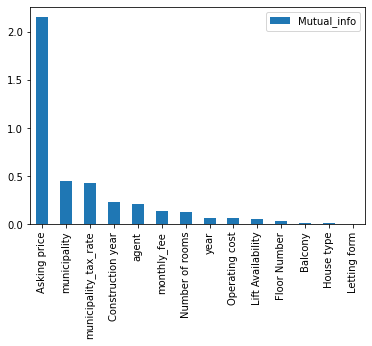

In [11]:
from sklearn.feature_selection import mutual_info_regression
pd.DataFrame(mutual_info_regression(X_train,y_train),index=X.columns,columns=['Mutual_info']).sort_values(by='Mutual_info', ascending=False).plot(kind='bar')

In [12]:
pd.DataFrame(mutual_info_regression(X_train,y_train),index=X.columns,columns=['Mutual_info'])

,Mutual_info
monthly_fee,0.134282
agent,0.214547
municipality,0.449622
municipality_tax_rate,0.429055
Number of rooms,0.124560
House type,0.016282
Asking price,2.152493
Balcony,0.023543
Construction year,0.234290
Operating cost,0.066108


We can see that while the asking price has a high level of mutual information shared with the sold price, features like floor number, balcony, house type and letting form has less mutual information. However, as the latter mentioned features also have a non-zero mutual information shared with the target variable we leave them as it is for model training.

### Initial model training - Polynomial linear regression

In [13]:
def compute_mape(y_true, y_pred):
    y_true = np.array(y_true).reshape(1,-1)
    y_pred = np.array(y_pred).reshape(1,-1)

    abs_error = np.abs(np.array(y_true) - np.array(y_pred))
    perc_error = (abs_error/np.array(y_true))*100
    mean_mape = np.mean(perc_error)
    median_mape = np.median(perc_error)

    return mean_mape

In [14]:
def lr_model(lm, X_train, y_train):
    lcv = cross_validate(lm, X_train, y_train,
    cv=10, scoring=["neg_mean_squared_error",'r2'],
    return_train_score=True,
    return_estimator=True)

    lm.fit(X_train, y_train)

    return lm

def lr_predict(model):
    #Test accuracy
    #predictions on test   data
    y_pred_mcv = model.predict(X_test)
    multi_mse = mean_squared_error(y_test.ravel(), y_pred_mcv.ravel())
    multi_r2 = r2_score(y_test.ravel(), y_pred_mcv.ravel())
    mape = compute_mape(y_test, y_pred_mcv)
    
    sns.distplot(np.array(y_test).reshape(1,-1)-np.array(y_pred_mcv).reshape(1,-1)).set(title="Predicion error distribution")
    

    print("MSE: ",np.round(multi_mse,2))
    print("R squared: ",np.round(multi_r2,2))
    print("Mean Absolute Percentage Error: ",np.round(mape,2))
    print("Accuracy: ", np.round(100-mape,2))
    


In [15]:
#Polynomial linear regression wirh cross validation
lm = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model = lr_model(lm, X_train, y_train)


In [16]:
#if test data has any unkown categorical variables remove them from prediction
test_df = pd.concat([X_test, y_test],axis=1)
test_df.dropna(inplace=True)
X_test, y_test = test_df.iloc[:,0:len(test_df.columns)-1], test_df.iloc[:,-1]

MSE:  109878407703.3
R squared:  0.92
Mean Absolute Percentage Error:  10.27
Accuracy:  89.73


/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


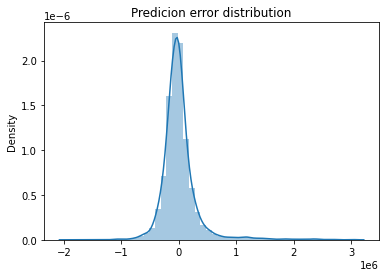

In [17]:
lr_predict(model)

### Outlier detection

Outlier detection should be carried out on the training data. If outlier detection is carried out on the entire dataset (training + test) then the model would have access to the information about the test set not used to train the model causing data lekage. This will make us over estimating the model's performance.

In [18]:
train_df = pd.concat([X_train, y_train], axis=1)

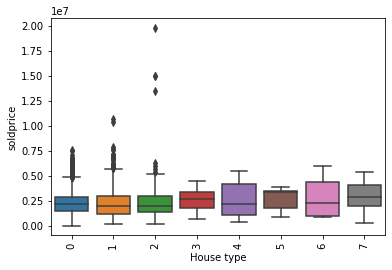

In [19]:
sns.boxplot(data=train_df,x='House type', y='soldprice')
x=plt.xticks(rotation=90)

Here we depict the box-plots on the sale prices with respect to the housing type. We can see that apartments, houses, and holiday homes have outliers.

#### IsolationForest for outlier detection

In [20]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05)
outlier_score = iso.fit_predict(X_train.values)
inliers = outlier_score != -1
outliers = outlier_score == -1

print("Total outliers detected : {} ".format(np.sum(outliers)))

Total outliers detected : 865 


In [21]:
#remove outlier data
X_train, y_train = X_train[inliers], y_train[inliers]

MSE:  120458382796.93
R squared:  0.91
Mean Absolute Percentage Error:  11.28
Accuracy:  88.72


/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


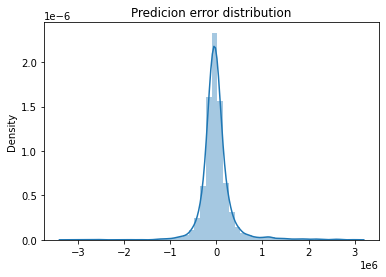

In [22]:
lm = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model = lr_model(lm, X_train, y_train)
lr_predict(model)

After removing about 865 outlier data points the accuracy drops from 89.73 to 88.99. 

### RandomForestRegressor

MSE:  60923723725.11
R squared:  0.96
Mean Absolute Percentage Error:  7.75
Accuracy:  92.25


/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


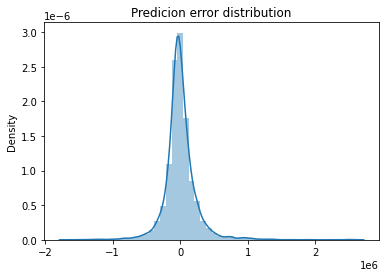

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = make_pipeline(RandomForestRegressor()) 
model = lr_model(rf, X_train, y_train)
lr_predict(model)


By using RandomForestRegressor we can improve the accuracy further upto 92.28% with a r-sqaured value of 0.96 which is remarkable.

When comparing with polynomial LR and RandomForestRegressor performs better.

### Model Selection

In [24]:
n_estimators = [int(x) for x in np.linspace(start=100,stop=200,num=2)]
m_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(start=10, stop=20, num=2)]
min_samples_split = [5, 10]

In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required to decide a leaf node
mln_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'mln_samples_leaf': mln_samples_leaf,
               'bootstrap': bootstrap
               }



In [26]:
random_grid

{'n_estimators': [100, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, None],
 'min_samples_split': [5, 10],
 'mln_samples_leaf': [2, 4],
 'bootstrap': [True, False]}

In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
rf_random.best_params_


In [ ]:
best_model = rf_random.best_estimator_
lr_predict(best_model)


After grid search we can see that the accuracy has slightly increased from 92.29 to 92.32.